In [7]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Definimos la clase para manejar los datasets.
class MiDataset(Dataset):
    #Constructor de la clase. Carga los archivos CSV a tensores PyTorch
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        # Extraer las primeras 5 columnas como entradas (medidas antropométricas y objetivos de paso)
        self.inputs = torch.tensor(self.data.iloc[:, :5].values, dtype=torch.float32)
        # Extraer las siguientes 30 columnas como salidas (15 pares de coordenadas X, Y)
        self.outputs = torch.tensor(self.data.iloc[:, 5:].values, dtype=torch.float32)

    def __len__(self):
        ##Devuelve el número total de muestras en el dataset.
        return len(self.data)
    def __getitem__(self, idx):
        ##Permite acceder a una muestra específica del dataset.
                ##Parámetro:
        ##- idx (int): Índice de la muestra a recuperar.
                ##Retorna:
        ##- Un par (input, output) correspondiente a la fila idx del CSV.
        return self.inputs[idx], self.outputs[idx]

In [2]:
# Definimos la red neuronal
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 32),  # Capa de entrada
            nn.ReLU(),
            nn.Linear(32, 64),  # Capa oculta
            nn.ReLU(),
            nn.Linear(64, 128),  # Capa oculta
            nn.ReLU(),
            nn.Linear(128, 256),  # Capa oculta
            nn.ReLU(),
            nn.Linear(256, 30)  # Capa de salida con 30 valores
        )

    def forward(self, x):
        return self.model(x)

# Crear el modelo
modelo = MLP()

In [3]:
# Definimos la función de pérdida y el optimizador
criterio = nn.MSELoss()  # MSE = Mean Squared Error
optimizador = optim.Adam(modelo.parameters(), lr=0.001)  # Tasa de aprendizaje de 0.001

In [4]:
# Cargamos de los datos para entrenamiento y validación.
train_dataset = MiDataset("datos_train.csv")
valid_dataset = MiDataset("datos_valid.csv")
# Creamos un DataLoader para manejar los datos en batches de 32 muestras
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Recorremos los datos para asegurar que está todo ok
for batch_inputs, batch_outputs in train_loader:
    print("Entradas del batch:", batch_inputs.shape)  # Debería ser [32, 5] si hay 32 muestras
    print("Salidas del batch:", batch_outputs.shape)  # Debería ser [32, 30] para los 15 pares (X, Y)
    break  # Solo mostramos el primer batch

Entradas del batch: torch.Size([32, 5])
Salidas del batch: torch.Size([32, 30])


Época 1: MSE entrenamiento: 30436.3210, RMSE entrenamiento: 174.4601, MSE validación: 559.2857, RMSE validación: 23.6492
  Error Porcentual entrenamiento: 20.15%
  Error Porcentual validación: 2.73%
Entrenamiento finalizado. Se ha guardado el mejor modelo.
Época 2: MSE entrenamiento: 2038.1691, RMSE entrenamiento: 45.1461, MSE validación: 356.7250, RMSE validación: 18.8872
  Error Porcentual entrenamiento: 5.21%
  Error Porcentual validación: 2.18%
Entrenamiento finalizado. Se ha guardado el mejor modelo.
Época 3: MSE entrenamiento: 1696.5589, RMSE entrenamiento: 41.1893, MSE validación: 326.1801, RMSE validación: 18.0605
  Error Porcentual entrenamiento: 4.76%
  Error Porcentual validación: 2.09%
Entrenamiento finalizado. Se ha guardado el mejor modelo.
Época 4: MSE entrenamiento: 1578.3936, RMSE entrenamiento: 39.7290, MSE validación: 280.1027, RMSE validación: 16.7363
  Error Porcentual entrenamiento: 4.59%
  Error Porcentual validación: 1.93%
Entrenamiento finalizado. Se ha guardad

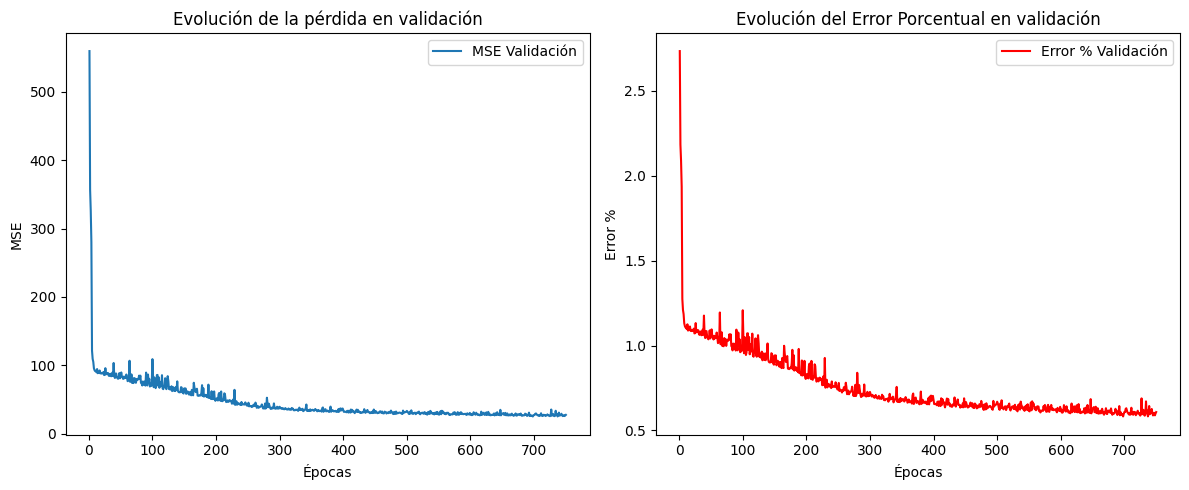

In [5]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
# Configuración de entrenamiento y validación
num_epochs = 750 # 750 épocas
mejor_loss_valid = float("inf")
paciencia_contador = 0  # Contador para añadir early stopping
paciencia = 10  # Límite para detener el entrenamiento si la pérdida de validación no mejora
epochs = []  # Lista para almacenar los números de época
# Listas para almacenar métricas
loss_valid_hist = []
error_porcentual_valid_hist = []

for epoch in range(num_epochs):
    modelo.train()  # Modo entrenamiento
    total_loss_train = 0
    total_rmse_train = 0
    total_salida_train = 0  # Para calcular el valor promedio de la salida (batch_outputs)

    for batch_inputs, batch_outputs in train_loader:
        # Forward: calcular predicciones
        predicciones = modelo(batch_inputs)

        # Calcular la pérdida (MSE)
        loss = criterio(predicciones, batch_outputs)

        # Backpropagation y optimización
        optimizador.zero_grad()
        loss.backward()
        optimizador.step()

        # Acumulamos las pérdidas de todos los batches
        total_loss_train += loss.item()

        # Sumar los valores reales para obtener su promedio
        total_salida_train += batch_outputs.sum().item()

    # Validación
    modelo.eval()  # Modo evaluación
    total_loss_valid = 0
    total_rmse_valid = 0
    total_salida_valid = 0  # Para calcular el valor promedio de la salida (batch_outputs)

    with torch.no_grad():  # No calcular gradientes en validación
        for batch_inputs, batch_outputs in valid_loader:
            predicciones = modelo(batch_inputs)
            loss = criterio(predicciones, batch_outputs)
            # Acumulamos las pérdidas de todos los batches
            total_loss_valid += loss.item()

            # Sumar los valores reales para obtener su promedio
            total_salida_valid += batch_outputs.sum().item()

    # Calcular RMSE para cada época completa del entrenamiento
    total_rmse_train = torch.sqrt(torch.tensor(total_loss_train)).item()
    # Calcular RMSE para cad época completa de la validación
    total_rmse_valid = torch.sqrt(torch.tensor(total_loss_valid)).item()

    # Promedio de pérdidas y RMSE
    #avg_loss_train = total_loss_train / len(train_loader.dataset)
    #avg_rmse_train = total_rmse_train / len(train_loader.dataset)
    #avg_loss_valid = total_loss_valid / len(valid_loader.dataset)
    #avg_rmse_valid = total_rmse_valid / len(valid_loader.dataset)

    # Promedio de las salidas reales (para cálculo de porcentaje)
    avg_salida_train = total_salida_train / len(train_loader.dataset)
    avg_salida_valid = total_salida_valid / len(valid_loader.dataset)

    # Cálculo del error porcentual
    error_porcentual_train = (total_rmse_train / avg_salida_train) * 100
    error_porcentual_valid = (total_rmse_valid / avg_salida_valid) * 100

     # Guardar métricas para graficar
    loss_valid_hist.append(total_loss_valid)
    error_porcentual_valid_hist.append(error_porcentual_valid)
    epochs.append(epoch + 1)  # Guardar la época actual

    # Imprimir los resultados
    print(f"Época {epoch+1}: MSE entrenamiento: {total_loss_train:.4f}, RMSE entrenamiento: {total_rmse_train:.4f}, "
          f"MSE validación: {total_loss_valid:.4f}, RMSE validación: {total_rmse_valid:.4f}")
    print(f"  Error Porcentual entrenamiento: {error_porcentual_train:.2f}%")
    print(f"  Error Porcentual validación: {error_porcentual_valid:.2f}%")

    # # Early stopping: si la pérdida en validación no mejora, contamos épocas sin mejora
    # if total_loss_valid < mejor_loss_valid:
    #     mejor_loss_valid = total_loss_valid
    #     paciencia_contador = 0
    torch.save(modelo.state_dict(), "NN.pth")  # Guardamos el mejor modelo
    # else:
    #     paciencia_contador += 1
    #     if paciencia_contador >= paciencia:
    #         print(f"Deteniendo entrenamiento temprano en la época {epoch} por falta de mejora en validación.")
    #         break  # Salimos del bucle

    # # Cargar el mejor modelo encontrado
    #modelo.load_state_dict(torch.load("NN.pth"))
    print("Entrenamiento finalizado. Se ha guardado el mejor modelo.")

    # Mostrar la pérdida cada 10 épocas
    #if epoch % 10 == 0:
     #   print(f"Época {epoch}, Pérdida: {total_loss_train / len(train_loader.dataset)}")

    # Graficamos la evolución del error de validación
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_valid_hist, label='MSE Validación')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.title('Evolución de la pérdida en validación')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, error_porcentual_valid_hist, label='Error % Validación', color='r')
plt.xlabel('Épocas')
plt.ylabel('Error %')
plt.title('Evolución del Error Porcentual en validación')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import torch
import torch.nn as nn

# Asegurarnos de que el modelo está cargado correctamente
modelo = MLP()
modelo.load_state_dict(torch.load("NN.pth"))  # Cargamos el modelo entrenado
modelo.eval()  # Modo evaluación

# Cargamos los datos de test
datos_test = pd.read_csv("datos_test.csv")

# Separamos las entradas y salidas
entradas_test = torch.tensor(datos_test.iloc[:, :5].values, dtype=torch.float32)
salidas_ideales = torch.tensor(datos_test.iloc[:, 5:].values, dtype=torch.float32)

# Inicializamos el cálculo del RMSE total
total_rmse = 0
total_muestras = len(entradas_test)
resultados = []  # Lista para almacenar los resultados
errores_rmse_porcentual = []
total_mse = 0
rmse_promedio2=0
diferencia_promedio=torch.zeros_like(salidas_ideales[0])
rmse_min = float("inf")
rmse_max = float("-inf")
indice_rmse_min = -1
indice_rmse_max = -1

# Predicciones y cálculo del RMSE
for i in range(total_muestras):
    entrada = entradas_test[i].unsqueeze(0)
    salida_ideal = salidas_ideales[i].squeeze(0)
    # Obtener la predicción
    salida_predicha = modelo(entrada).detach().squeeze(0)
    diferencias = salida_predicha - salida_ideal
    print(f"Diferencias: {diferencias}")
    diferencia_promedio += diferencias

    # Calcular el RMSE
    mse_loss = nn.MSELoss()(salida_predicha, salida_ideal)
    rmse = torch.sqrt(mse_loss).item()
    total_rmse += rmse
    total_mse += mse_loss

    # Calcular el error porcentual RMSE de cada muestra
    promedio_salida_ideal = salida_ideal.mean().item()  # Promedio de la salida ideal para esta muestra
    error_rmse_porcentual = (rmse / promedio_salida_ideal) * 100 if promedio_salida_ideal != 0 else 0

    # Verificar y actualizar mínimos y máximos
    if error_rmse_porcentual < rmse_min:
        rmse_min = error_rmse_porcentual
        indice_rmse_min = i
    if error_rmse_porcentual > rmse_max:
        rmse_max = error_rmse_porcentual
        indice_rmse_max = i

    # Guardar el error RMSE en porcentaje en la lista
    errores_rmse_porcentual.append(error_rmse_porcentual)

    # Guardar los datos en una lista
    fila = entrada.squeeze(0).tolist() + salida_predicha.tolist()  # Concatenamos correctamente
    resultados.append(fila)  # Añadimos la fila a la lista
    # Imprimir las salidas ideales vs las predicciones
    print(f"Entrada {i+1}: {entrada}")
    print(f"  Salida Ideal: {salida_ideal}")
    print(f"  Salida Predicha: {salida_predicha.squeeze()}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  Error RMSE en %: {error_rmse_porcentual:.2f}%")
    print("-" * 50)

# Calcular el RMSE promedio global
rmse_promedio = total_rmse / total_muestras
print(f"\nRMSE Promedio Global: {rmse_promedio:.4f}")
diferencia_promedio = torch.tensor(diferencia_promedio) / total_muestras
# Calcular el promedio global de las salidas ideales
promedio_salida_ideal_global = salidas_ideales.mean().item()

# Calcular el error RMSE promedio en porcentaje global
rmse_porcentual_promedio = (rmse_promedio / promedio_salida_ideal_global) * 100
print(f"Error Promedio RMSE en % (Global): {rmse_porcentual_promedio:.2f}%")
print(f"Diferencia promedio: {diferencia_promedio}")

# Crear un DataFrame con las entradas y predicciones
columnas_entrada = [f"Entrada_{i+1}" for i in range(5)]
columnas_salida = [f"Salida_Predicha_{i+1}" for i in range(30)]
df_resultados = pd.DataFrame(resultados, columns=columnas_entrada + columnas_salida)
# Mostrar valores extremos al final
print(f"\n🔹 RMSE Mínimo %: {rmse_min:.4f}% en la muestra {indice_rmse_min+1}")
print(f"🔹 RMSE Máximo %: {rmse_max:.4f}% en la muestra {indice_rmse_max+1}")

# Guardar en un CSV
df_resultados.to_csv("resultados_predicciones.csv", index=False)
print("📂 Predicciones guardadas en 'resultados_predicciones.csv'")

Diferencias: tensor([ 1.6745e-02, -3.3556e+00, -2.1199e+00,  2.8494e-01,  1.5860e-01,
         4.8685e+00,  1.1773e-02, -2.1424e-01,  3.4720e+00, -3.5348e+00,
         3.8156e-01,  5.7335e-01, -5.0835e-01,  7.9664e+00, -2.8308e-02,
        -5.8489e-01, -8.0164e-01, -1.2040e+00,  1.4261e+00, -4.7556e-02,
         1.4258e+00, -1.4268e+00,  1.5752e+00, -1.2774e-01, -3.4864e-03,
        -1.7696e+00,  5.0456e-01, -5.1571e-01,  1.3228e+00,  5.5990e-01])
Entrada 1: tensor([[38., 38., 17., 70., 33.]])
  Salida Ideal: tensor([  0.0000,  32.1717,  60.5251,  -2.1247,  84.7291,  59.6278,   0.0000,
         11.2856,   5.1417,  12.8112,  38.0987,   8.7775,  81.7962, 110.1407,
          0.0000,   3.7758,   6.4647,  -0.3064,  52.9849,  15.2733,  69.9308,
         -0.3398,  86.9879,  13.9726,   0.0000,   0.5059,  33.6788,   6.9791,
         83.6788,  -6.9791])
  Salida Predicha: tensor([ 1.6745e-02,  2.8816e+01,  5.8405e+01, -1.8397e+00,  8.4888e+01,
         6.4496e+01,  1.1773e-02,  1.1071e+01,  8.61

<ipython-input-6-12af9b0b0056>:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diferencia_promedio = torch.tensor(diferencia_promedio) / total_muestras
